In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from scipy.linalg import sqrtm

2022-10-02 15:41:01.685391: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.transform import resize
import numpy as np
import time
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'

In [3]:
import tensorflow.keras.applications.inception_v3 as pretrained_models
preprocess = tf.keras.applications.inception_v3.preprocess_input

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2022-09-27 09:23:25.443620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 09:23:35.454830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46711 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [4]:
if tf.config.list_physical_devices('GPU'):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
    info = tf.config.experimental.get_memory_info('GPU:0')
print(info)

{'current': 0, 'peak': 0}


2022-09-29 17:24:53.687240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 17:24:54.424285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46711 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [9]:
imgs_names = []
folder = "/media/user/data/sandeep/test/learning/datasets/bitmojis/"
for filename in os.listdir(folder):
        imgs_names.append(filename)        

In [10]:
len(imgs_names)

130227

In [11]:
tot_imgs = []
for name in imgs_names:
    cur = image.imread(folder+name)
    tot_imgs.append(cur)


In [12]:
tot_imgs = np.array(tot_imgs)
# print(tot_imgs.shape,tot_imgs.dtype)
tot_imgs = (tot_imgs-0.5)*2

In [13]:
noise_dim = 100
BATCH_SIZE = 256

In [9]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256*4,use_bias = False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 1024)))

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    tf.keras.layers.Dropout(0.3)

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    tf.keras.layers.Dropout(0.3)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    tf.keras.layers.Dropout(0.3)
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = "tanh" ))
    
    
    return model

generator = generator_model()
# print(generator.summary())


In [10]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[128,128, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = discriminator_model()


In [11]:

def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.ones_like(fake_output)
    real_loss = tf.reduce_mean((real_output-real_labels)**2)
    fake_loss = tf.reduce_mean((fake_output+fake_labels)**2)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

def generator_loss(fake_output):
#     fake_labels = tf.ones_like(fake_output)
    return 0.5*(tf.reduce_mean((fake_output)**2))

generator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss,disc_loss

In [13]:
def train(dataset, epochs):
    batches = dataset.shape[0]//BATCH_SIZE
    
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        start = time.time()
        cur = 0
        tot_gen_ls = 0
        tot_disc_ls = 0
        for x in range(batches):
            gen_ls,disc_ls = train_step(dataset[cur:cur+BATCH_SIZE])
            tot_gen_ls += gen_ls
            tot_disc_ls += disc_ls
            cur += BATCH_SIZE
        
        gen_losses.append(tot_gen_ls/batches)
        disc_losses.append(tot_disc_ls/batches)
    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(gen_losses[-1],disc_losses[-1])
    return gen_losses,disc_losses


In [14]:
gen_losses,disc_losses = train(tot_imgs, 50)


2022-09-29 17:26:18.878221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-29 17:26:20.670325: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Time for epoch 1 is 161.1374192237854 sec
tf.Tensor(2.9525173, shape=(), dtype=float32) tf.Tensor(2.2688096, shape=(), dtype=float32)
Time for epoch 2 is 155.2117896080017 sec
tf.Tensor(0.8646259, shape=(), dtype=float32) tf.Tensor(0.94907963, shape=(), dtype=float32)
Time for epoch 3 is 155.27635145187378 sec
tf.Tensor(0.6833715, shape=(), dtype=float32) tf.Tensor(0.77813816, shape=(), dtype=float32)
Time for epoch 4 is 155.31682109832764 sec
tf.Tensor(0.65494764, shape=(), dtype=float32) tf.Tensor(0.7410111, shape=(), dtype=float32)
Time for epoch 5 is 155.3320198059082 sec
tf.Tensor(0.55504924, shape=(), dtype=float32) tf.Tensor(0.5935626, shape=(), dtype=float32)
Time for epoch 6 is 155.3968210220337 sec
tf.Tensor(0.60070556, shape=(), dtype=float32) tf.Tensor(0.61715376, shape=(), dtype=float32)
Time for epoch 7 is 155.3968207836151 sec
tf.Tensor(0.48218718, shape=(), dtype=float32) tf.Tensor(0.5143409, shape=(), dtype=float32)
Time for epoch 8 is 155.39840388298035 sec
tf.Tensor(

In [15]:
discriminator.save("ls_gan_discriminator")
generator.save("ls_gan_generator")

INFO:tensorflow:Assets written to: ls_gan_discriminator/assets


INFO:tensorflow:Assets written to: ls_gan_discriminator/assets


INFO:tensorflow:Assets written to: ls_gan_generator/assets


INFO:tensorflow:Assets written to: ls_gan_generator/assets


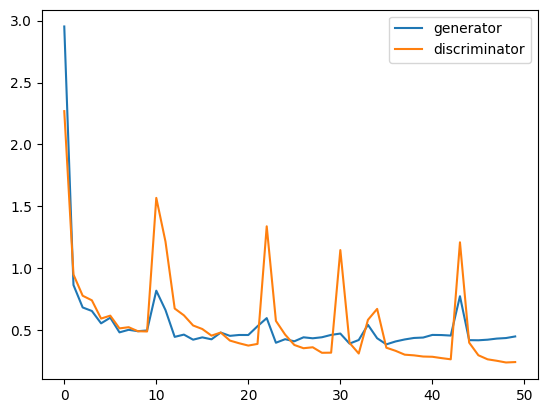

In [16]:
plt.plot(gen_losses)
plt.plot(disc_losses)
plt.legend(["generator","discriminator"])

In [17]:
def image_generate(n):
    noise = tf.random.normal(shape = (n*n,noise_dim))
    dt = generator(noise,training = False)
    imgs = (dt+1)/2
    fig,ax = plt.subplots(n,n)
    cur = 0
    if(n==1):
        ax.imshow(imgs[0])
        return
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(imgs[cur])
            ax[i,j].axis('off')
            cur += 1

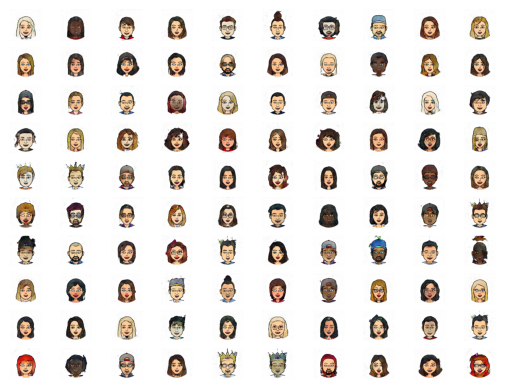

In [18]:
image_generate(10)

In [5]:
ls_gen = keras.models.load_model("/media/user/data/sandeep/test/learning/trained_models/gans/ls_gan_generator")
ls_disc = keras.models.load_model("/media/user/data/sandeep/test/learning/trained_models/gans/ls_gan_discriminator")

In [6]:
bi_gen = keras.models.load_model("/media/user/data/sandeep/test/learning/trained_models/gans/bi_gan_generator")
bi_disc = keras.models.load_model("/media/user/data/sandeep/test/learning/trained_models/gans/bi_gan_discriminator")
bi_encoder = keras.models.load_model("/media/user/data/sandeep/test/learning/trained_models/gans/bi_gan_encoder")


In [8]:
dc_gen = keras.models.load_model("/media/user/data/sandeep/test/learning/trained_models/gans/dcgan_genera")
dc_disc = keras.models.load_model("/media/user/data/sandeep/test/learning/trained_models/gans/dcgan_discrim")


In [18]:
samp_img = tot_imgs[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


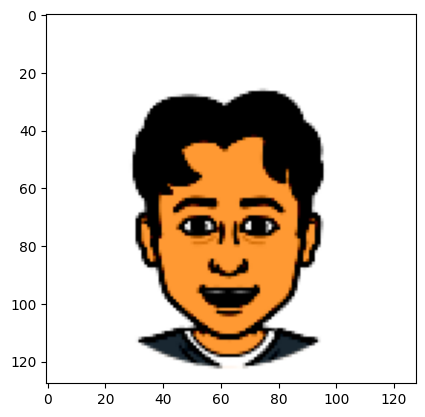

In [19]:
plt.imshow(samp_img)

In [151]:
def grid_gen(gen):
    for d in range(0,100,10):
        lat = tf.random.normal((1,101))
        latent_traversal(lat,gen,d)

In [182]:
def latent_traversal(lat,gen,d):
    n = 10
    latents = np.tile(lat,(n,1))
    travs = np.linspace(-20,40,n)
    for i in range(n):
        latents[i][d] = travs[i]
        
    imgs = gen(latents)
    imgs = (imgs+1)/2
    fig,ax = plt.subplots(1,10)
    
    for i in range(n):
        ax[i].imshow(imgs[i])
        ax[i].axis("off")
        
    

In [ ]:
def latent_traversal(lat,gen,d):
    n = 10
    latents = np.tile(lat,(n,1))
    travs = np.linspace(-20,40,n)
    for i in range(n):
        latents[i][d] = travs[i]

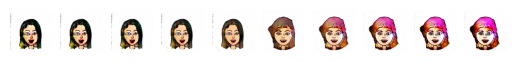

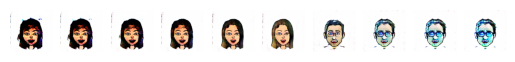

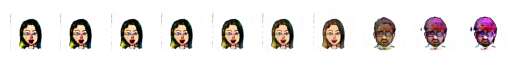

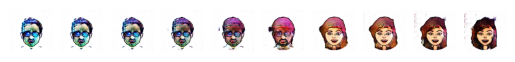

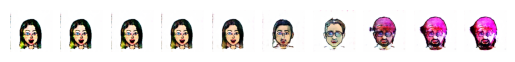

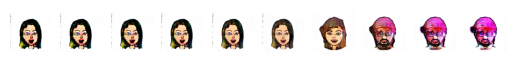

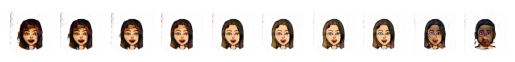

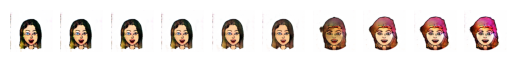

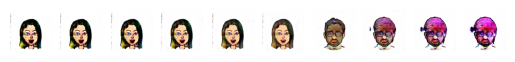

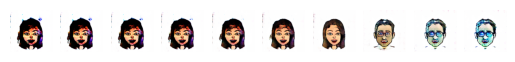

In [172]:
grid_gen(dc_gen)

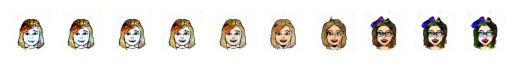

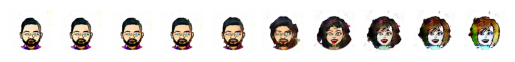

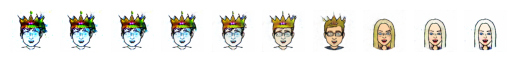

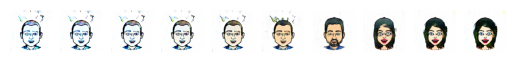

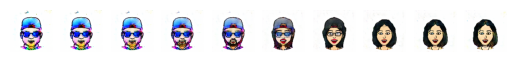

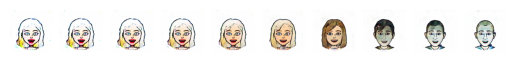

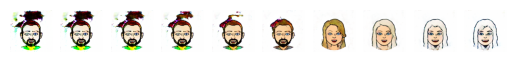

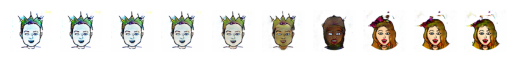

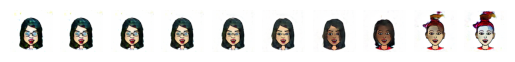

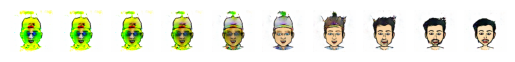

In [174]:
grid_gen(ls_gen)

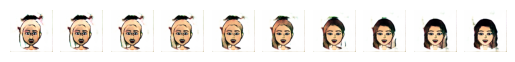

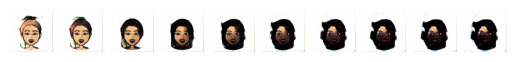

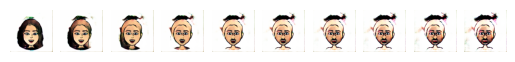

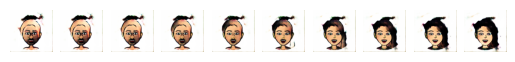

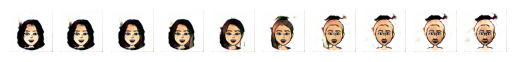

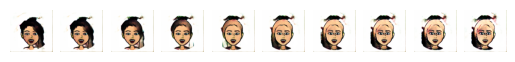

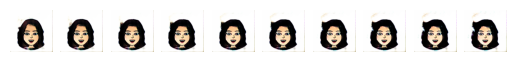

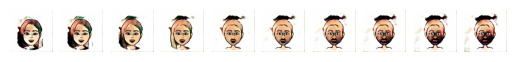

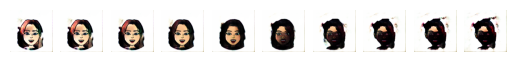

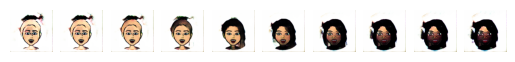

In [183]:

grid_gen(bi_gen)

In [19]:
inception = pretrained_models.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [20]:
def scale_for_incept(imgs):
    tot = []
    for img in imgs:
        tot.append(resize(img,(299,299,3)))
        
    return np.array(tot)

In [21]:
def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    print("generated_features done")
    act2 = model.predict(images2)
    print("calculating")
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [22]:
def overall_fids(model):
    all_fids = []
    for i in range(20):
        noise = tf.random.normal(shape = (1000,noise_dim))
        generated_imgs = generator(noise,training = False)
        real_indices = random.sample(range(120000),1000)
        real_imgs = []
        for x in real_indices:
            real_imgs.append(tot_imgs[x])
        rl = (np.array(real_imgs)+1)/2
        gn = (generated_imgs+1)/2
        generated_imgs = scale_for_incept(rl)
        real_imgs = scale_for_incept(gn)
        gener_preproce = preprocess(generated_imgs)
        real_preproce = preprocess(real_imgs)
        cur_fid = calculate_fid(inception,generated_imgs,real_imgs)
        all_fids .append(cur_fid)
            
    return all_fids

In [23]:
all_fids = overall_fids(inception)

32/32 [==============================] - 4s 65ms/step
generated_features done
32/32 [==============================] - 1s 35ms/step
calculating
32/32 [==============================] - 1s 34ms/step
generated_features done
32/32 [==============================] - 1s 34ms/step
calculating
32/32 [==============================] - 1s 34ms/step
generated_features done
32/32 [==============================] - 1s 34ms/step
calculating
32/32 [==============================] - 1s 33ms/step
generated_features done
32/32 [==============================] - 1s 34ms/step
calculating
32/32 [==============================] - 1s 34ms/step
generated_features done
32/32 [==============================] - 1s 33ms/step
calculating
32/32 [==============================] - 1s 32ms/step
generated_features done
32/32 [==============================] - 1s 33ms/step
calculating
32/32 [==============================] - 1s 32ms/step
generated_features done
32/32 [==============================] - 1s 33ms/step
calc

In [24]:
min_fids = min(all_fids)
max_fids = max(all_fids)
avg_fids = sum(all_fids)/len(all_fids)
print(min_fids,max_fids,avg_fids)

3.145596768553409 4.784231346424134 3.980569496726234
